<CENTER>
    <a href="http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html" class="icons"><img src="../images/ATLASOD.gif" style="width:40%"></a>
</CENTER>

# <CENTER><h1> Reconstruction of invariant mass of Z boson decaying into two leptons </h1></CENTER>

## C++ notebook example

This notebook provides the analysis of Z boson decaying into two leptons. This analysis shows you how to use diferent tools to perform the analysis, such as:

* TFile: It is useful to open and read ROOT files.
* TTree: Used to create a tree with the information of each event 
* TH1F: This allows us to define our histograms.
* TF1: We use it to create a function to fit our histogram.
* TLegend: Which lets us put a legend to identify signal from background in the final plot.
* TLatex: It is used to put Latex text in our plots.

At the end of this analysis, you will be able to get a plot with the invariant mass of Z boson computed from the two lepton final system. This plot will show you the gaussian fit function on our histogram. Here you can find many tools to perform the desired selection of events, how to declarate histograms, variables, read ROOT files and so on.

The first step is to load some basic libraries of c++:

In [1]:
#include <TChain.h>
#include <vector>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>

The data we want to use to perform our analysis can be found in [folder 1largeRjet1lep/MC](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/) and the name of the root file that we are going to use is called "mc_361106.Zee.1largeRjet1lep.root". Due to we only will use one root file, we can use TFile instead of TChain to extract the information of the file mentioned above:

In [2]:
TFile *file = TFile::Open("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1largeRjet1lep/MC/mc_361106.Zee.1largeRjet1lep.root");

Now, we can define a tree in which we are going to save the information of "mini" tree of the root file, and also create a variable called nentries that contains the total number of events stored in the root file:

In [3]:
TTree *tree = (TTree*) file->Get("mini");
int nentries = tree->GetEntries();
cout << nentries << endl;

53653


Once we have defined our tree, we can create different variables that we will use to perform the analysis. Some of these variables are integers or vectors that contains data of float type. The idea is to save the information of the events of each entry, which is contained in our tree, in the new variables we have just created:

In [4]:
UInt_t  lepton_n = -1;  //number of preselected leptons

vector<float>   *lepton_charge;  
vector<float>   *lepton_type;
vector<float>   *lepton_pt = 0; //transverse momentum of the lepton
vector<float>   *lepton_eta = 0; //pseudorapidity of the lepton
vector<float>   *lepton_phi = 0;  //azimuthal angle of the lepton
vector<float>   *lepton_E   = 0;  //energy of the lepton

tree->SetBranchAddress("lep_n",      &lepton_n);
tree->SetBranchAddress("lep_charge", &lepton_charge);
tree->SetBranchAddress("lep_type",   &lepton_type);
tree->SetBranchAddress("lep_pt",     &lepton_pt);
tree->SetBranchAddress("lep_eta",    &lepton_eta);
tree->SetBranchAddress("lep_phi",    &lepton_phi);
tree->SetBranchAddress("lep_E",    &lepton_E);

If we only want to use a fraction of all events, we can define a variable called "fraction_events" as follow:

In [5]:
float fraction_events = 1.0;
float events_to_run = nentries*fraction_events;

cout << "Total # events = "  << nentries
     << ". Events to run = " << events_to_run
     << " corresponding to " << fraction_events*100
     << "% of total events!" << endl;

Total # events = 53653. Events to run = 53653 corresponding to 100% of total events!


The main information of the two leptons will be stored into 2 TLorentzVector (pT, eta, phi and E of the lead and trail leptons):

In [6]:
TLorentzVector leadLepton = TLorentzVector();
TLorentzVector trailLepton = TLorentzVector();

Next, we define the canvas, which allows us to visualize the graphics, and the histogram in which we are going to save the invariant mass of each event: 

In [7]:
TCanvas *canvas = new TCanvas();
TH1F *hist = new TH1F("variable", "Mass of the Z boson", 30, 40, 140);

The next line of the code will make the corresponding analysis of the reconstruction of the invariant mass of Z boson. Some cuts will be implemented in order to get the events we want to consider. There will be three cuts: The first cut selects the events in which we can find at leats two leptons (no matters if they are electrons or muons). The second one selects the events in which we find leptons with opposite charge, and the third one choose the events with leptons of the same flavour. When all cuts are applied, the code computes the invariant mass using the information of each lepton (their pT, eta, phi and E) and fill the invariant mass calculated in GeV into the histogram we had created:

In [8]:
int nbytes = 0;
for (int ii=0; ii<events_to_run; ii++)
{
    nbytes = (Int_t)tree->GetEntry(ii);

    // Cut #1: At least 2 leptons
    
    if (lepton_n >= 2)
    {
        // Cut #2: Leptons with opposite charge
        if (lepton_charge->at(0) != lepton_charge->at(1))
        {
            // Cut #3: Leptons of the same family (2 electrons or 2 muons)
            if (lepton_type->at(0) == lepton_type->at(1))
            {
                // Let's define one TLorentz vector for each, e.i. two vectors!
                leadLepton.SetPtEtaPhiE(lepton_pt->at(0), lepton_eta->at(0), lepton_phi->at(0), lepton_E->at(0));
                trailLepton.SetPtEtaPhiE(lepton_pt->at(1), lepton_eta->at(1), lepton_phi->at(1), lepton_E->at(1));
                // Next line: addition of two TLorentz vectors above --> ask mass very easy (divide by 1000 to get value in GeV)
                TLorentzVector invmass = TLorentzVector();
                invmass = leadLepton + trailLepton;
                float inv_mass_GeV = invmass.M()/1000.;
                hist->Fill(inv_mass_GeV);
            }
        }
    }
    
}

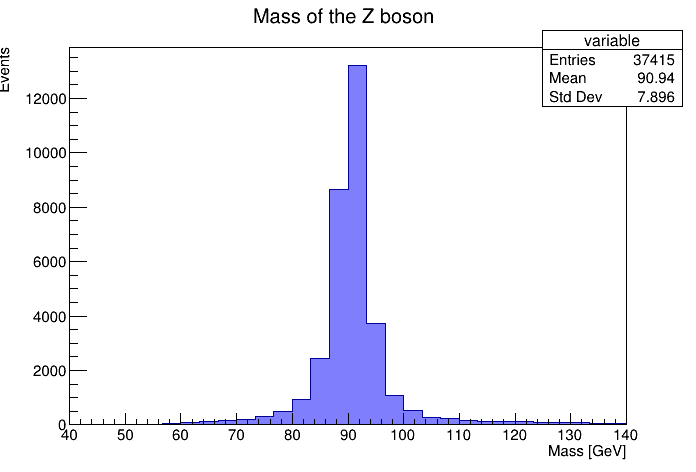

In [9]:
hist->GetXaxis()->SetTitle("Mass [GeV]");
hist->GetYaxis()->SetTitle("Events");
hist->SetFillColorAlpha(kBlue, 0.5); //Fill the histogram with color blue but with less intensity
hist->Draw();
c1->Draw();

If we want to improve our analysis, we can fit our data to a determined function. For example, we are goint to fit this histogram to a Gaussian function using TF1 as follow: 

In [10]:
TF1 *fit = new TF1("fit", "gaus", 40, 140);
fit->SetParameter(0, 13000); // Set a initial guess value to the amplitud of the Gauss function
fit->SetParameter(1, 91); // Set a initial guess value to the mean of the Gauss function
fit->SetParameter(2, 8); // Set a initial guess value to the standard deviation of the Gauss function

The function SetParameter could help us to converge the fit more easily if we have information about these parameters (amplitud, mean and std deviation). As we know, the mass of Z boson is around 91 GeV approximately, and according to the stats given by the histograms in the latest graphic, the std deviation was around 7.9, so we can use these values as an initial guess of the Gaussian function fit. However, if you want, you can comment these lines and verify that the fit has to converge to the same results anyway. 

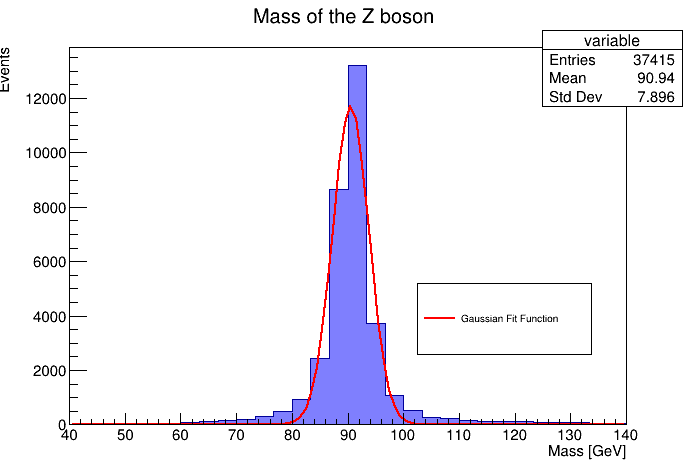

 FCN=4566.46 FROM MIGRAD    STATUS=CONVERGED     117 CALLS         118 TOTAL
                     EDM=3.81273e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.17175e+04   1.07117e+02   2.27502e+00  -5.86083e-07
   2  Mean         9.05837e+01   1.93654e-02   6.36473e-04  -8.60466e-04
   3  Sigma        3.27786e+00   2.29218e-02   3.07557e-05  -8.62874e-02


In [11]:
TLegend *leg = new TLegend(0.6, 0.25, 0.85, 0.4); // Declares a legend to the function fit and his position in canvas
leg->AddEntry(fit, "Gaussian Fit Function","l"); // Gives a name to the legend and use a line "l" to show the fit

hist->Draw();
hist->Fit("fit", "R"); 
leg->Draw();

c1->Draw();

When we need to use these parameters, we can save them into new variables such as follow:

In [12]:
double amplitude = fit->GetParameter(0);
double mean = fit->GetParameter(1);
double std = fit->GetParameter(2);

cout << "amplitude: " << amplitude << endl;
cout << "mean: " << mean << endl;
cout << "standard deviation: "<< std << endl;

amplitude: 11717.5
mean: 90.5837
standard deviation: 3.27786


Finally, we can beautify our plots adding some text latex using TLatex and print the parameters of the gaussian function fit in the plot:

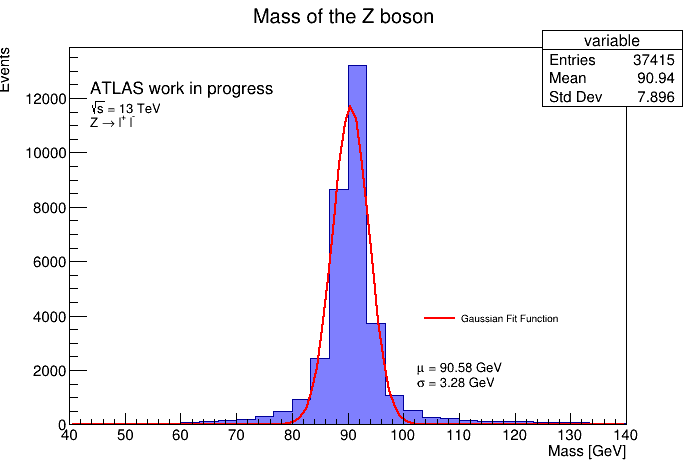

 FCN=4566.46 FROM MIGRAD    STATUS=CONVERGED     117 CALLS         118 TOTAL
                     EDM=3.61443e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.17175e+04   1.07117e+02   2.27502e+00  -5.67520e-07
   2  Mean         9.05837e+01   1.93654e-02   6.36474e-04  -8.54564e-04
   3  Sigma        3.27786e+00   2.29218e-02   3.07557e-05  -8.38868e-02


Info in <TCanvas::Print>: pdf file plots/Mass_of_Z_boson_fit.pdf has been created


In [13]:
hist->Draw();
hist->Fit("fit", "R"); 
leg->SetBorderSize(0);
leg->Draw();

TLatex l;
l.SetNDC();
l.SetTextFont(42); 
l.SetTextColor(kBlack); 
l.SetTextSize(0.04);  
l.DrawLatex(0.13,0.8,"ATLAS work in progress"); // The first two arguments give the initial point of the text in the canvas

TLatex o;
o.SetNDC();
o.SetTextFont(42);
o.SetTextColor(kBlack);
o.SetTextSize(0.03);
double dely = 0.04; 
o.DrawLatex(0.13,0.8-dely, Form("#sqrt{s} = 13 TeV")); // The first two arguments give the initial point of the text in the canvas
o.DrawLatex(0.13,0.77-dely, Form("Z #rightarrow l^{+} l^{-}")); // The first two arguments give the initial point of the text in the canvas

TLatex p;
p.SetNDC();
p.SetTextFont(42);
p.SetTextColor(kBlack);
p.SetTextSize(0.03);
p.DrawLatex(0.6,0.25-dely, Form("#mu = 90.58 GeV")); // The first two arguments give the initial point of the text in the canvas
p.DrawLatex(0.6,0.22-dely, Form("#sigma = 3.28 GeV")); // The first two arguments give the initial point of the text in the canvas

c1->Draw();
c1->Print("plots/Mass_of_Z_boson_fit.pdf");